# Sleepstudy data: Reaction times in a sleep deprivation study
#### For more detail: https://www.rdocumentation.org/packages/lme4/versions/1.1-34/topics/sleepstudy

#### The data contains the average reaction time (in milliseconds) for 18 subjects and is a function of Days 


In [1]:
import os
os.chdir("..")

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jenkspy import jenks_breaks
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder


from utils.Thesis_models import *
from utils import Thesis_viz as viz

WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_probability\python\internal\backend\numpy\_utils.py:48: The name tf.logging.TaskLevelStatusMessage is deprecated. Please use tf.compat.v1.logging.TaskLevelStatusMessage instead.



WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_probability\python\internal\backend\numpy\_utils.py:48: The name tf.control_flow_v2_enabled is deprecated. Please use tf.compat.v1.control_flow_v2_enabled instead.

C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflo

WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\tf_utils.py:585: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.

WARNING  [optimizer.py:123] `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
WARNING  [optimizer.py:123] `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [3]:
def run_model(model, all_args):
    arg_names = model.__code__.co_varnames[:model.__code__.co_argcount]
    model_args = {k: all_args[k] for k in arg_names if k in all_args}
    return model(**model_args)

def get_reduced_data(label_df, column_break):
    
    zone_indices = {zone : list(label_df[label_df[column_break] == zone].index) \
                                                for zone in np.unique(label_df[column_break])}
    mapping_dict = {value: key for key, values in zone_indices.items() for value in values}
    data = df.copy()
    data['gE_new'] = df['gV'].map(mapping_dict)
    
    return data
    
def plot_mixed_effects(data, feature, group, target,legends = False):
    
    fig, ax = plt.subplots(figsize=(10, 7), dpi=100)

    col = str(group)

    for i in np.unique(data[col]):
        sns.regplot(x = data[data[col] == i][str(feature)], y = data[data[col] == i][str(target)],\
                    label = str(group)+":"+str(i),scatter_kws={"alpha": 1})
    
    if legends == True:
        plt.legend(loc='best')
    plt.ylabel(str(target), fontsize = 12)
    plt.xlabel(str(feature), fontsize = 12)

In [4]:
data = pd.read_csv("datasets\sleepstudy.csv", index_col=False)
data = data.iloc[:,1:]
data

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


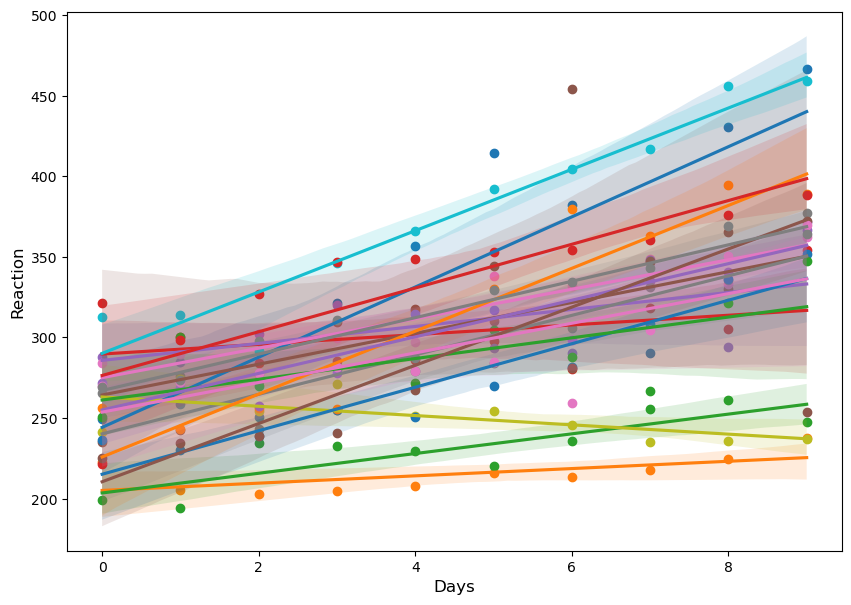

In [5]:
plot_mixed_effects(data, 'Days','Subject','Reaction')

In [6]:
df = data.rename({'Reaction':'y', 'Days':'f0', 'Subject': 'gV'}, axis=1)
ordinal_encoder = OrdinalEncoder()
df['gV'] = ordinal_encoder.fit_transform(np.array(df['gV']).reshape(-1,1))
df['gV'] = df['gV'].astype(int)
df

,y,f0,gV
0,249.5600,0,0
1,258.7047,1,0
2,250.8006,2,0
3,321.4398,3,0
4,356.8519,4,0
...,...,...,...
175,329.6076,5,17
176,334.4818,6,17
177,343.2199,7,17
178,369.1417,8,17


### Initial performance(RMSE) with considering individual subjects

In [7]:
mse_with_Visible_groups = np.sqrt(MixedLM(df, mode='both')[0])
mse_with_Visible_groups

28.134992272533545

In [8]:
md = sm.MixedLM.from_formula(f"y ~ {' + '.join([i for i in df.columns if i.startswith('f')])} + (1|gV)" \
                             ,df, groups = 'gV', re_formula='~'+'+'.join([i for i in df.columns if i.startswith('f')]))

mdf = md.fit()
mdf_re = pd.DataFrame([])
    
try:
    est_intercept = [((i+1)*mdf.fe_params['1 | gV']) + mdf.random_effects[i]['gV'] + mdf.fe_params[0] for i in mdf.random_effects.keys()]
    mdf_re['intercept'] = est_intercept

    for idx, f_i in enumerate([i for i in df.columns if i.startswith('f')]):
        
        est_slope = [mdf.fe_params[str(f_i)] + mdf.random_effects[i][str(f_i)] for i in range(len(mdf.random_effects))]
        mdf_re['slope_'+str(f_i)] = est_slope

except IndexError: pass
mdf_re

,intercept,slope_f0
0,252.157674,19.891615
1,209.842437,2.136539
2,210.844449,5.276866
3,275.607246,5.659137
4,273.729975,7.375935
5,260.717372,10.245134
6,268.361221,10.217738
7,244.297511,11.622468
8,251.500678,-0.350402
9,287.417974,19.006557


### Clustering K-Means: Trying with minimum 2 to 17 clusters.

In [9]:
pca_df = mdf_re.copy()
X = np.array(pca_df)

K_range = range(2, len(mdf_re))

for k in K_range:
    
    kmeans = KMeans(n_clusters= k, random_state=42)
    labels = kmeans.fit_predict(X)
    pca_df['K-'+str(k)] = labels

In [10]:
res = pd.DataFrame([])

for itr, i in enumerate([col for col in pca_df.columns if col.startswith('K')]):
       
    reduced_df = get_reduced_data(pca_df, i)
    reduced_df.drop(['gV'], axis=1, inplace=True)
    reduced_df = reduced_df.dropna()
    try:
    
        test_mixedlm,_,_,_  = MixedLM(reduced_df,mode='both')

        res.at[itr, 'name'] = i
        res.at[itr, 'test_mixedlm'] = np.sqrt(test_mixedlm)
        
    except np.linalg.LinAlgError: pass

In [11]:
res

,name,test_mixedlm
1,K-3,40.379085
2,K-4,36.541244
3,K-5,33.298340
4,K-6,31.903185
5,K-7,29.304418
6,K-8,27.780358
7,K-9,27.971402
8,K-10,26.669604
9,K-11,26.470472
10,K-12,26.946687


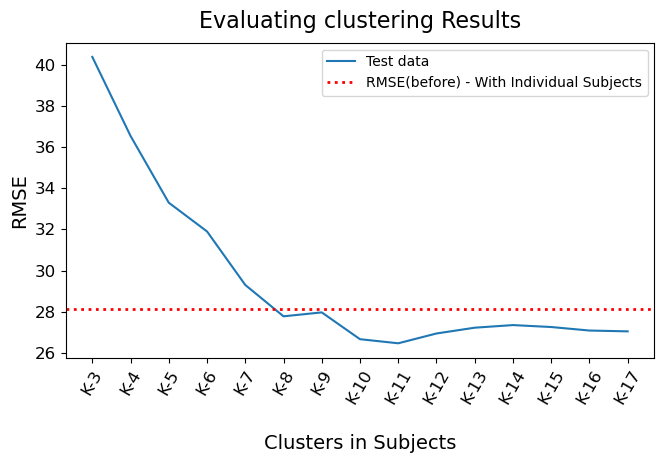

In [12]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)
results = res.copy()
results.reset_index(drop=True, inplace=True)

ax.plot(results.name, results.test_mixedlm,  label='Test data')

plt.axline((0, mse_with_Visible_groups), (1, mse_with_Visible_groups), color = 'r', ls=':',\
           linewidth = 2, label = 'RMSE(before) - With Individual Subjects')

# ax.set_xticks(res.name,range(len(res)))
ax.tick_params(axis='x', labelsize=12, rotation=60)
ax.tick_params(axis='y', labelsize=12)
ax.legend()
ax.set_title("Evaluating clustering Results", fontsize = 16, y = 1.02)
ax.set_xlabel('\nClusters in Subjects', fontsize = 14)
ax.set_ylabel("RMSE", fontsize = 14)
plt.tight_layout(pad = 2)
# plt.savefig("Results\SleepStudy_result.pdf",format = 'pdf',bbox_inches='tight')

### List of clusters with better performance found than considering 18 subjects individually.

In [13]:
results[results.test_mixedlm < mse_with_Visible_groups]

,name,test_mixedlm
5,K-8,27.780358
6,K-9,27.971402
7,K-10,26.669604
8,K-11,26.470472
9,K-12,26.946687
10,K-13,27.227905
11,K-14,27.354989
12,K-15,27.260649
13,K-16,27.090182
14,K-17,27.049582


In [14]:
reduced_df = get_reduced_data(pca_df, 'K-8')
reduced_df['Subject'] = ordinal_encoder.inverse_transform(np.array(reduced_df['gV']).reshape(-1,1))
grouped = reduced_df.groupby('gE_new').agg({'Subject': 'unique'}).reset_index()
grouped = grouped.rename(columns={'gE_new':'Subjects Clusters Found'})
grouped = grouped.set_index('Subjects Clusters Found')
grouped

,Subject
Subjects Clusters Found,
0,"[334, 350]"
1,"[330, 331, 333, 352, 372]"
2,"[309, 310]"
3,[337]
4,"[332, 351, 369, 371]"
5,"[349, 370]"
6,[308]
7,[335]


#### The K-8 is the first improved performance occured where RMSE imporved from 28.13 to 27.78 and if the best performance is considered then for K-11, RMSE improved to 26.47.